# Ансамбли

### OzonMasters, "Машинное обучение 1"

В этом ноутбуке вам предлагается реализовать алгоритмы бустинга и бэггинга.

In [1]:
import numpy as np
import numpy.testing as npt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
import pylab as plt

## 1. Сэмплирование случайных объектов и признаков

Во многих ансамблевых алгоритмах используется прием, заключающийся в обучении на случайной подвыборке объектов или на случайном подмножестве признаков.

Реализуйте класс, который будет упрощать семплирование различных подмассивов данных: `BaseSampler`.

В классе `BaseSampler` реализуйте метод `sample_indices` который по числу сущностей `n_objects` возращает случайную подвыборку индексов. Используйте атрибут `self.random_state`, чтобы результаты семпплирования воспроиводились. Используйте атрибут `self.bootstrap`, если нужно выбрать случайную подвыборку с возвращением.

У класса `ObjectSampler` реализован метод `sample`, который возвращает случайную подвыборку объектов обучения и ответы для них.

В классе `FeaturesSampler` реализован метод `sample`, который возвращает случайную подвыборку признаков для объектов.

## 2. Бэггинг (2 балла)

Суть бэггинга заключается в обучении нескольких "слабых" базовых моделей и объединении их в одну модель, обладающую бОльшей обобщающей способностью. Каждая базовая модель обучается на случайно выбранном подмножестве объектов и на случайно выбранном подмножестве признаков для этих объектов.

Ниже вам предлагается реализовать несколько методов класса `Bagger`:
* `fit` - обучение базовых моделей
* `predict_proba` - вычисление вероятностей ответов.

Тогда алгоритм случайный лес будет бэггингом над решающими деревьями. Реализация случайного веса представлена в классе `RandomForestClassifier`.

## 3. Градиентный бустинг (2 балла)

Бустинг последовательно обучает набор базовых моделей таким образом, что каждая следующая модель пытается исправить ошибки работы предыдущей модели. Логика того, как учитываются ошибки предыдущей модели может быть разной. В алгоритме градиентного бустинга каждая следующая модель обучается на "невязках" предыдущей модели, минимизируя итоговую функцию потерь. У каждого следующего алгоритма вычисляется вес $\alpha$, с которым он входит в ансамбль. Также есть параметр скорости обучения (learning rate), который не позволяет алгоритму переобучитсья. Вес $\alpha$ можно находить, используя одномерную оптимизацию. Можно записать процедуру обучения по шагам (будем рассматривать случай бинарной классификации c метками классов {0,1}, чтобы не усложнять жизнь):
1. Настройка базового алгоритма $b_0$.
    
    Алгоритм настраиваются на $y$ с помощью функции MSE.
    
    
2. Будем обозначать текущий небазовый алгоритм - $a$:
    
    $$a_i(x) = \sum_{j=0}^i \alpha_j b_j(x) $$
    
3. Настройка базового алгоритма $b_i$ (обычно это регрессионное дерево):
    
    $$b_i = \arg \min_b \sum_{j=1}^l (b(x_j) + \nabla L(a_{i-1}(x_j), y))^2,$$
    т.е. выход очередного базового алгоритма подстраивается под антиградиент функции потерь
    
4. Настройка веса базового алгоритма $\alpha_i$:
    
    $$\alpha_i = \min_{\alpha > 0} \sum_{j=1}^l L(a_{i-1} + \alpha b_i(x_j), y) $$
    
В случае классфикации будем использовать логистическую функцию потерь. Немного упростим ее:

$$L = -y\log\sigma(a) - (1-y)\log(1 - \sigma(a)) = -\log(1 - \sigma(a)) - y \log \frac{\sigma(a)}{1 - \sigma(a)},$$
где $\sigma$ - функция сигмоиды. Ответ после очередного базового алгоритма надо прогонять через сигмоиду, т.к. не гарантируется, что ответы будут лежать на [0,1] - в этом особенность базового алгоритма (который является регрессионным).

Преобразуем:
$$\log (1 - \sigma(a)) = \log \frac{1}{1 + \exp(a)} = -\log(1 + \exp(a)) $$

$$\log (\frac{\sigma(a)}{1 - \sigma(a)}) = \log(\exp(a)) = a $$
 
Таким образом:

$$L = -ya + \log(1 + \exp(a))$$

Тогда будем вычислять градиент как:
 
$$\nabla L = - y + \sigma(a)$$

В классе `Booster` реализуйте методы:
* `_fit_first_estimator` – построение первой модели (первого приближения данных);
* `fit` – обучение алгоритма градиентного бустинга (обучение первой и последующих базовых моделей);
* `predict` – получение предсказаний алгоритма градиентного бустинга.

В классе `GradientBoostingClassifier` реализуйте методы:
* `_fit_base_estimator` - обучение очередной базовой модели;
* `_gradient` - расчет градиента функции ошибки;
* `_loss` - расчет функции ошибки (для одномерно оптимизации).

## Эксперименты (3 балла)

Скачайте датасейт для экспериментов: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Колонка с ответами - RainTommorow.

In [2]:
%load_ext autoreload
%autoreload 2

from ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv('weatherAUS.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
data.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

Выделите признаки год/месяц/день:

In [6]:
data['year'] = data.Date.dt.year
data['month'] = data.Date.dt.month
data['day'] = data.Date.dt.day

Посмотрим какие года есть в выборке:

In [7]:
data['year'].value_counts()

2016    17934
2014    17885
2015    17885
2009    16789
2010    16782
2013    16415
2012    15409
2011    15407
2017     8623
2008     2270
2007       61
Name: year, dtype: int64

Разделите выборку на три части (train, val и test) по временному принципу:
    
* train - 2007-2014
* val - 2015
* test - 2016-2017

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

Здесь вы можете делать всевозможные преобразования признаков. 

Для того, чтобы получить качество, необходимое для преодоления бейзлайна, вам достаточно закодировать все категориальные признаки с помощью `LabelEncoder`, а также разумно обработать пропущенные значения.

Источник: https://www.kaggle.com/mdshahbazmuneer/91-accuracy-complete-explanation-with-comments

In [9]:
categorical_features = [column_name for column_name in data.columns if data[column_name].dtype =="O"]

In [10]:
missing_cat = data[categorical_features].isnull().sum() # Total missing values 
print(missing_cat)


Location            0
WindGustDir     10326
WindDir9am      10566
WindDir3pm       4228
RainToday        3261
RainTomorrow     3267
dtype: int64


<BarContainer object of 6 artists>

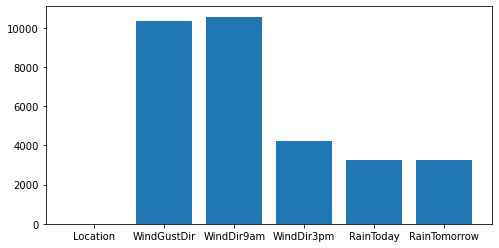

In [11]:
plt.figure(figsize= (8,4))
plt.bar(missing_cat.index,missing_cat.values ) # by visualization we can see that winDir3pm has large number of missing values 


In [12]:
data = data[~data["RainTomorrow"].isnull()]

In [13]:
cat_features_with_null = [features for features in categorical_features if data[features].isnull().sum()]  
for each_feature in cat_features_with_null:
    data[each_feature] = data[each_feature].fillna(data[each_feature].mode()[0])    

In [14]:
data[categorical_features].isnull().sum()

Location        0
WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

In [15]:
num_col = [num_col for num_col in data.columns if data[num_col].dtype !="O"] 
#numerical features extraction from the data

In [16]:
missing_num = data[num_col].isnull().sum()    # counting missing values in each  num_feature 
missing_num

Date                 0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
year                 0
month                0
day                  0
dtype: int64

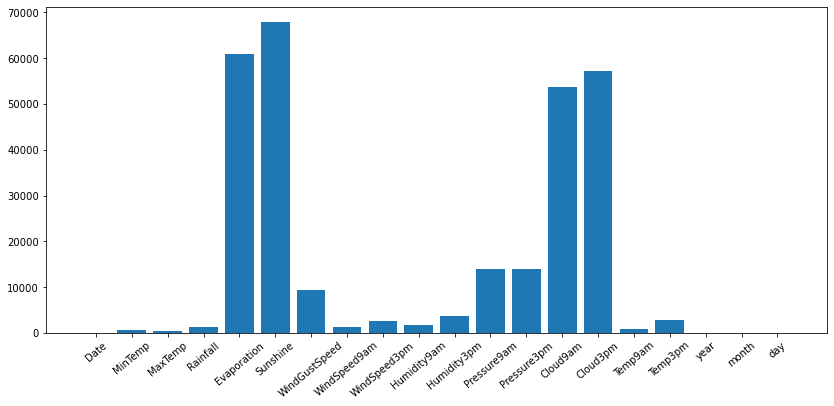

In [17]:
plt.figure(figsize=(14,6))
plt.bar(missing_num.index,missing_num.values)    # ploting missing values 
plt.xticks(rotation=40);

In [18]:
num_col_with_null_values = [col for col in num_col if data[col].isnull().sum()]
missing_values = data[num_col_with_null_values].isnull().sum()
missing_values

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
dtype: int64

<AxesSubplot:>

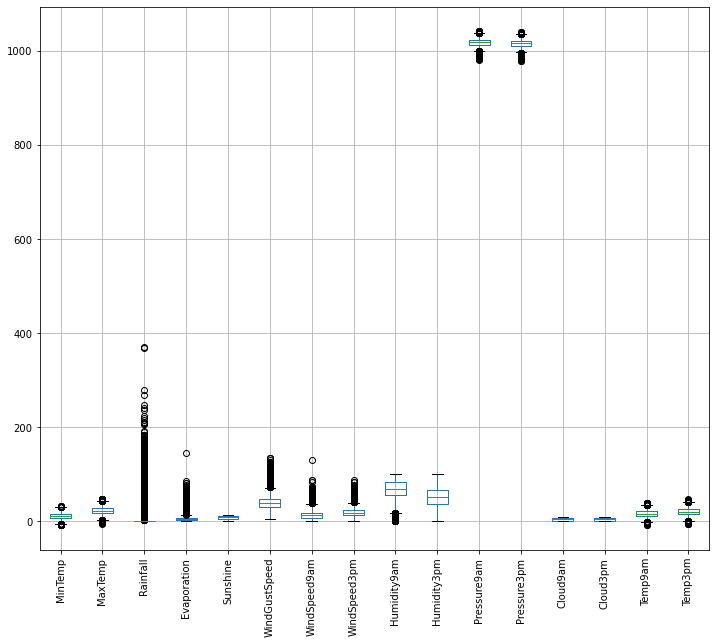

In [19]:
plt.figure(figsize=(12,10))
data.boxplot(num_col_with_null_values,rot = 90)

In [20]:
features_with_outliers = num_col_with_null_values
for feature in features_with_outliers:
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    IQR = q3-q1
    lower_limit = q1 - (IQR*1.5)
    upper_limit = q3 + (IQR*1.5)
    data.loc[data[feature]<lower_limit, feature] = lower_limit
    data.loc[data[feature]>upper_limit, feature] = upper_limit

# after running this the outliers will be removed from our numerical features of the data 

<AxesSubplot:>

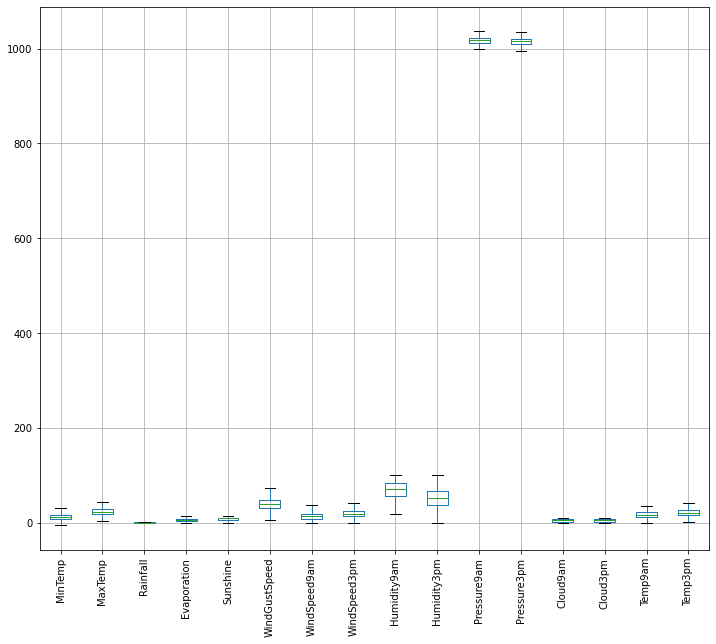

In [21]:
plt.figure(figsize=(12,10))
data.boxplot(num_col_with_null_values,rot = 90)

In [22]:
for features in num_col_with_null_values:
    data[features] = data[features].fillna(data[features].mean()) 

In [23]:
data[num_col_with_null_values].isnull().sum() 

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [24]:
data.isnull().sum() 

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
year             0
month            0
day              0
dtype: int64

In [25]:
cat_fea = [i for i in data.columns if data[i].dtype == "O"]
cat_fea 

['Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']

In [26]:
label_en = LabelEncoder()
for f in cat_fea:
    data[f] = label_en.fit_transform(data[f])

Ваш таргет - RainTommorow. Удалите его из обучающих данных, также удалите признак RISK_MM.

In [27]:
target_data = data['RainTomorrow']
data.drop(['RainTomorrow', 'Date'], axis=1, inplace=True)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  int64  
 1   MinTemp        142193 non-null  float64
 2   MaxTemp        142193 non-null  float64
 3   Rainfall       142193 non-null  float64
 4   Evaporation    142193 non-null  float64
 5   Sunshine       142193 non-null  float64
 6   WindGustDir    142193 non-null  int64  
 7   WindGustSpeed  142193 non-null  float64
 8   WindDir9am     142193 non-null  int64  
 9   WindDir3pm     142193 non-null  int64  
 10  WindSpeed9am   142193 non-null  float64
 11  WindSpeed3pm   142193 non-null  float64
 12  Humidity9am    142193 non-null  float64
 13  Humidity3pm    142193 non-null  float64
 14  Pressure9am    142193 non-null  float64
 15  Pressure3pm    142193 non-null  float64
 16  Cloud9am       142193 non-null  float64
 17  Cloud3pm       142193 non-nul

In [29]:
indexes = {
    'train': (data['year']>=2007) & (data['year']<=2014) ,
    'val': (data['year']==2015) ,
    'test': (data['year']>=2016) & (data['year']<=2017)
}

In [30]:
X_train, y_train = data[indexes['train']].values, target_data[indexes['train']].values
X_val, y_val = data[indexes['val']].values, target_data[indexes['val']].values
X_test, y_test = data[indexes['test']].values, target_data[indexes['test']].values

Для каждого из алгоритмов достигнутое качество должно быть: 
* RandomForest > 0.84
* GradientBoosting > 0.845
* AdaBoost > 0.83

Обучите каждый из алгоритмов до нужного качества, используйте валидационную выборку, чтобы подбирать гиперпараметры. Получите качество (accuracy) выше необходимого и на validation, и на test.

**Подсказка:** для визуализации прогресса обучения можно использовать бибилиотеку [`tqdm`](https://tqdm.github.io/).

**Подсказка:** некоторые из подходов анасмблирования тривиальным образом поддаются распараллеливанию на несколько потоков/процессов. Для параллелизации можно использовать `multiprocessing.Pool`.

In [31]:
from sklearn.metrics import accuracy_score

# Случайный Лес

In [32]:
from tqdm import tqdm

n_estimators = [90,140,150]
mo_samples = [0.5,0.7, 0.9]
mf_samples = [0.2,0.5,0.8]

results = {}

for n in n_estimators:
    for o in mo_samples:
        for f in mf_samples:
            
    
            model = RandomForestClassifier(n_estimators=n, 
                                   max_objects_samples=o, 
                                   max_features_samples=f, 
                                   max_depth=100, 
                                   min_samples_leaf=5,
                                   random_state=1)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            results[(n, o, f)] = accuracy

In [33]:
results

{(90, 0.5, 0.2): 0.8181765422784516,
 (90, 0.5, 0.5): 0.8499796877720388,
 (90, 0.5, 0.8): 0.8532876791828681,
 (90, 0.7, 0.2): 0.8181765422784516,
 (90, 0.7, 0.5): 0.8502118275201671,
 (90, 0.7, 0.8): 0.8535198189309965,
 (90, 0.9, 0.2): 0.8181185073414196,
 (90, 0.9, 0.5): 0.8509662817015844,
 (90, 0.9, 0.8): 0.8535778538680285,
 (140, 0.5, 0.2): 0.8136498171899483,
 (140, 0.5, 0.5): 0.850792176890488,
 (140, 0.5, 0.8): 0.8536939237420927,
 (140, 0.7, 0.2): 0.8156810399860717,
 (140, 0.7, 0.5): 0.8504439672682955,
 (140, 0.7, 0.8): 0.8531716093088039,
 (140, 0.9, 0.2): 0.8164354941674888,
 (140, 0.9, 0.5): 0.850734141953456,
 (140, 0.9, 0.8): 0.8535198189309965,
 (150, 0.5, 0.2): 0.814056061749173,
 (150, 0.5, 0.5): 0.8506761070164239,
 (150, 0.5, 0.8): 0.8535778538680285,
 (150, 0.7, 0.2): 0.8157971098601358,
 (150, 0.7, 0.5): 0.8498636178979746,
 (150, 0.7, 0.8): 0.853809993616157,
 (150, 0.9, 0.2): 0.8156230050490395,
 (150, 0.9, 0.5): 0.8506180720793918,
 (150, 0.9, 0.8): 0.85293

Лучшее значение accuracy: 0.8536939237420927

При параметрах

n_estimators=140, 

object_sample = 0.5,

feature_sample = 0.8,

max_depth=5




In [34]:
model = RandomForestClassifier(n_estimators=140, 
                                   max_objects_samples=0.5, 
                                   max_features_samples=0.8, 
                                   max_depth=100, 
                                   min_samples_leaf=5,
                                   random_state=1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy on test:',accuracy)

Accuracy on test: 0.8413413413413413


# Градиентный бустинг

In [35]:
n_estimators = [50,100,150]
mf_samples = [0.25,0.5,0.75]

results = {}

for n in n_estimators:
        for f in mf_samples:
            
            model = GradientBoostingClassifier(n_estimators=n, 
                                               max_features_samples=f, 
                                               max_depth=5,
                                               random_state=6)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            results[(n, f)] = accuracy


In [36]:
results

{(50, 0.25): 0.8568278103418258,
 (50, 0.5): 0.8558412164122802,
 (50, 0.75): 0.8558992513493123,
 (100, 0.25): 0.8578724392084035,
 (100, 0.5): 0.8576402994602751,
 (100, 0.75): 0.8534037490569323,
 (150, 0.25): 0.8556090766641519,
 (150, 0.5): 0.8539260634902212,
 (150, 0.75): 0.8511984214497127}

Лучшее значение accuracy: 0.8578724392084035

При параметрах

n_estimators=100, 

max_features_samples=0.25, 

max_depth=5

In [37]:
model = GradientBoostingClassifier(n_estimators=100, 
                                   max_features_samples=0.25, 
                                   max_depth=5, 
                                   random_state=6)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy on test:',accuracy)

Accuracy on test: 0.8450758450758451


## 3.1 AdaBoost (3 балла)

В алгоритме AdaBoost всем объектам обучения присваивается вес `weight`, который определяет степень важности объекта при обучении. И если текущая модель ошибается на некотором объекте, его вес увеличивается, и этот объект будет больше влиять на обучение следующей модели. Также, так как модели обучаются последовательно, они не равносильны между собой, поэтому у каждой модели тоже есть вес `alpha`, который определяет вес модели при суммировании ответов и зависит от количества ошибок `err` модели. На каждой итерации обучения, эти веса пересчитываются по формулам:

* $$\alpha_j = \log\left(\frac{1-err_j}{err_j}\right),$$
где $err_j$ - ошибка классификации

* $$w_{new}^t = \frac{w_{old}^{t}*\exp(-\alpha_j \cdot y(x^t) \cdot b_j(x^t))}{\sum\limits_{i=1}^m w_{old}^{t}*\exp(-\alpha_j \cdot y(x^i) \cdot b_j(x^i))}$$
Изначально все веса объектов $w^i$ равны (и нормированы на 1).

Вам предлагается полностью реализовать AdaBoost. Вы можете использовать предыдущие шаблоны, но учтите некоторые пункты:
* надо работать с метками {-1,1} - это обусловлено использованием экспоненциальной функции потерь
* метод `predict` представляет собой функцию сигмоид, примененную к сумме предсказаний всех моделей  